In [ ]:
%%bash
cd /content
# uncomment for gpu session ~ 10 min
#apt update && apt install cuda-11-8
pwd
pip install dl-backtrace
pip install graphviz
pip install lime
pip install shap
pip install grad-cam

/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully unin

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.64 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.0 which is incompatible.


In [ ]:
# Importing necessary libraries along with the MNIST Fashion dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
from lime import lime_image
import graphviz
from IPython.display import Image, display
import matplotlib.image as mpimg
from dl_backtrace.pytorch_backtrace import Backtrace as B
from tensorflow import keras

In [ ]:
# Load the fashion MNIST dataset
(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

# Take the first 10,000 records
X_train = X_train[:10000]
Y_train = Y_train[:10000]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).view(-1, 1, 28, 28) / 255.0
Y_train_tensor = torch.LongTensor(Y_train)
X_test_tensor = torch.FloatTensor(X_test).view(-1, 1, 28, 28) / 255.0
Y_test_tensor = torch.LongTensor(Y_test)

mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

4422102/4422102 [==============================] - 0s 0us/step


<ipython-input-3-2ebcab04e843>:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  X_train_tensor = torch.FloatTensor(X_train).view(-1, 1, 28, 28) / 255.0


In [ ]:
#Building model architecture to fit out data on
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.identity = nn.Identity()
        self.conv1 = nn.Conv2d(1, 48, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(48, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 28 * 28, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.identity(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Instantiate the model
num_classes = len(np.unique(Y_train))
model = SimpleCNN(num_classes)

In [ ]:
# Instantiate the model
num_classes = len(np.unique(Y_train))
model = SimpleCNN(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Combine input data and labels into a TensorDataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

# DataLoader for batching
batch_size = 256  # Adjust as needed
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.7473
Epoch [2/10], Loss: 1.8042
Epoch [3/10], Loss: 1.5283
Epoch [4/10], Loss: 1.5355
Epoch [5/10], Loss: 1.7372
Epoch [6/10], Loss: 1.5553
Epoch [7/10], Loss: 1.6611
Epoch [8/10], Loss: 1.6434
Epoch [9/10], Loss: 1.6516
Epoch [10/10], Loss: 1.5517


In [ ]:
model.eval()
model(X_test_tensor[0].reshape(1, 1, 28, 28))

tensor([[4.7057e-22, 1.4854e-16, 7.7648e-17, 1.5024e-15, 3.7557e-11, 3.7098e-03,
         2.5685e-13, 6.8460e-02, 1.9019e-05, 9.2781e-01]],
       grad_fn=<SoftmaxBackward0>)

# XAI Eval

## Backtrace Explainability

In [ ]:
#Creating a Backtrace object to inject our model to
backtrace = B(model=model)
#Getting output from every layer using .predict function
idx = 0
layer_outputs = backtrace.predict(X_test_tensor[idx].reshape(1, 1, 28, 28))

In [ ]:
#Calculating relevance of not only input feature layer , but every layer in the architecture
relevance = backtrace.eval(layer_outputs,mode='default',scaler=1)

/usr/local/lib/python3.10/dist-packages/dl_backtrace/pytorch_backtrace/backtrace/utils/prop.py:579: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  w=w.T


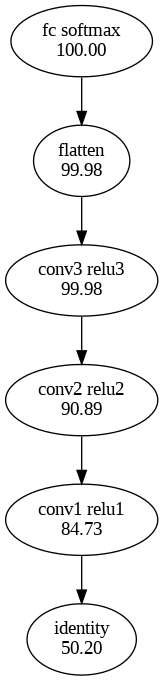

In [ ]:
relevance_data = {key.replace('/', ' ').replace(':', ' '): value for key, value in {layer: np.sum(values) if values.ndim == 1 else np.sum(values.flatten()) for layer, values in relevance.items()}.items()}

# Create a graph
graph = graphviz.Digraph('Relevance Tree', format='png')

# Add nodes and edges based on relevance values
for i, (layer, rel) in enumerate(list(relevance_data.items())):
    graph.node(layer, label=f'{layer}\n{rel:.2f}')
    if i > 0:
        graph.edge(list(relevance_data.keys())[i-1], layer)

# Display the graph
graph.render("relevance_tree_reverse", format="png", cleanup=True)

# Display the reversed image directly in the notebook
image_path = "relevance_tree_reverse.png"
display(Image(filename=image_path))


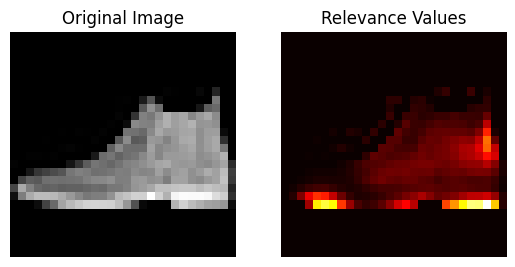

In [ ]:
# Assuming relevance_values and X_test[idx] are defined elsewhere in the script
relevance_values = relevance[list(relevance.keys())[-1]]

# File paths to save the images
original_image_path = 'original_image.png'
relevance_image_path = 'relevance_image.png'

# Visualize the original image
plt.subplot(1, 2, 1)
plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Save the original image
plt.imsave(original_image_path, X_test[idx].reshape(28, 28), cmap='gray')

# Visualize the relevance values
plt.subplot(1, 2, 2)
plt.imshow(relevance_values.reshape(28, 28), cmap='hot', interpolation='nearest')
plt.title('Relevance Values')
plt.axis('off')

# Save the relevance image
plt.imsave(relevance_image_path, relevance_values.reshape(28, 28), cmap='hot')

# Show the plot
plt.show()

In [ ]:
#Finding pixelwise relevance using contrast mode - which gives pixel relevances which contribute positively as well as negatively to the output
relevance = backtrace.eval(layer_outputs,mode='contrast')

pos=relevance[list(relevance.keys())[-1]]['Positive']
neg=relevance[list(relevance.keys())[-1]]['Negative']

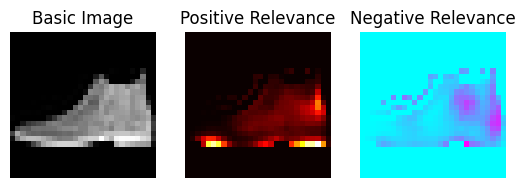

In [ ]:
basic_image = X_test[0].reshape(28, 28)
pos_relevance_values = pos.reshape(28, 28)
neg_relevance_values = neg.reshape(28, 28)

# Visualize the basic image
plt.subplot(1, 3, 1)
plt.imshow(basic_image, cmap='gray')
plt.title('Basic Image')
plt.axis('off')

# Visualize the positive relevance values
plt.subplot(1, 3, 2)
plt.imshow(pos_relevance_values, cmap='hot', interpolation='nearest')
plt.title('Positive Relevance')
plt.axis('off')

# Visualize the negative relevance values
plt.subplot(1, 3, 3)
plt.imshow(neg_relevance_values, cmap='cool', interpolation='nearest')
plt.title('Negative Relevance')
plt.axis('off')

plt.show()

